In [2]:
from pathlib import Path
from bs4 import BeautifulSoup

from nltk.probability import FreqDist
from nltk import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import numpy as np

from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import glob
import os
import pandas as pd
from datetime import datetime

In [3]:
stock = pd.read_csv("stock.csv",dtype = {'cik': str})
stock['datadate']=pd.to_datetime(stock['datadate'],format='%Y%m%d')
spx = pd.read_csv("spx.csv")
spx['caldt']=pd.to_datetime(spx['caldt'],format='%Y%m%d')

In [4]:
stock_new = pd.DataFrame(data = {'date':stock['datadate'],'cik':stock['cik'],
                     'stock':-stock.groupby(['cik'])['prccd'].diff(-4)/stock['prccd']})
spx_ret = ((spx['vwretd']+1)*(spx['vwretd']+1).shift(1)*(spx['vwretd']+1).shift(2)-1).shift(-3)
spx_new = pd.DataFrame(data = {'date':spx['caldt'], 'index':spx_ret})

In [5]:
ex_ret = stock_new.merge(spx_new, on = 'date').dropna().sort_values(by=['cik','date'])
ex_ret['ret'] = ex_ret['stock']-ex_ret['index']

In [6]:
# define dict

with open('fin_neg.txt', 'r') as f:
    fin_neg = [line.strip().lower() for line in f]
    
with open('h4n_inf.txt', 'r') as f:
    h4n_inf = [line.strip().lower() for line in f]

os.chdir(r'data')

In [7]:
data_file_list = glob.glob('*.txt')

In [8]:
# create function
def lemmatize_words(words):
    
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    
    return lemmatized_words

In [9]:
def get_freq(path, Dict):
    
    path_sep = path.replace('.','-').split('-')
    text = Path(path).read_text(encoding="utf8").lower()
    word_pattern = re.compile('\w+')
    text_lem = lemmatize_words(word_pattern.findall(text))
    lemma_english_stopwords = lemmatize_words(stopwords.words('english'))
    ten_k = [word for word in text_lem if word not in lemma_english_stopwords]
    fdist = FreqDist()
    for word in ten_k:
        fdist[word] += 1
    freq = sum([fdist[x] for x in Dict])/len(ten_k)

    return freq

In [10]:
def get_return(path):
    
    path_sep = path.replace('.','-').split('-')
    cik = path_sep[1]
    yyyy = int(path_sep[2])
    mm = int(path_sep[3])
    dd = int(path_sep[4])
    cik_ret = ex_ret[ex_ret['cik']==cik].drop_duplicates(subset=['date']).set_index('date')
    ret = cik_ret.iloc[cik_ret.index.get_loc(datetime(yyyy,mm,dd), method='bfill')][3]
    
    return ret

In [117]:
def get_tfidf(Dict, docs):
    
    vec = TfidfVectorizer(vocabulary=Dict)
    print(".")
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()

In [12]:
cik_ret = ex_ret[ex_ret['cik']=='0000014693'].set_index('date')
cik_ret.loc[cik_ret.index.drop_duplicates(keep='first')]

,cik,stock,index,ret
date,,,,
2016-01-04,0000014693,-0.018825,-0.033652,0.014826
2016-01-04,0000014693,-0.015962,-0.033652,0.017690
2016-01-05,0000014693,-0.040099,-0.046213,0.006115
2016-01-05,0000014693,-0.029348,-0.046213,0.016865
2016-01-06,0000014693,-0.024638,-0.033057,0.008418
...,...,...,...,...
2021-12-23,0000014693,0.001497,0.013945,-0.012448
2021-12-27,0000014693,0.004994,-0.002656,0.007650
2021-12-27,0000014693,0.008511,-0.002656,0.011167


In [47]:
from tqdm import tqdm

df = pd.DataFrame(data={'name':[], 'fin neg freq':[], 'h4n inf freq':[], 'return':[]})
freqs_fin_neg = list()
freqs_h4n_inf = list()
rets = list()

i = 0
for path in tqdm(data_file_list):
    i += 1
    try:
        add = pd.DataFrame(data = {'name':[data_file_list[i]], 'fin neg freq':[get_freq(path, fin_neg)], 'h4n inf freq':[get_freq(path, h4n_inf)], 'return':[get_return(path)]})
        df = pd.concat([df,add], ignore_index=True)
    except:
        pass

  0%|          | 0/10842 [00:00<?, ?it/s]C:\Users\yiyan\AppData\Local\Temp\ipykernel_13216\1519286417.py:9: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ret = cik_ret.iloc[cik_ret.index.get_loc(datetime(yyyy,mm,dd), method='bfill')][3]
100%|██████████| 10842/10842 [59:51<00:00,  3.02it/s] 


In [77]:
fin_neg_qt = np.quantile(df['fin neg freq'],[0,.2,.4,.6,.8,1])
h4n_inf_qt = np.quantile(df['h4n inf freq'],[0,.2,.4,.6,.8,1])

fin_ret_mean = list()
h4n_ret_mean = list()


for i in range(5):
    mean1 = np.mean(df[(df['fin neg freq']<fin_neg_qt[i+1]) & (df['fin neg freq']>=fin_neg_qt[i])]['return'])
    mean2 = np.mean(df[(df['h4n inf freq']<h4n_inf_qt[i+1]) & (df['h4n inf freq']>=h4n_inf_qt[i])]['return'])
    fin_ret_mean.append(mean1)
    h4n_ret_mean.append(mean2)

In [54]:
df.dropna().shape

(10804, 4)

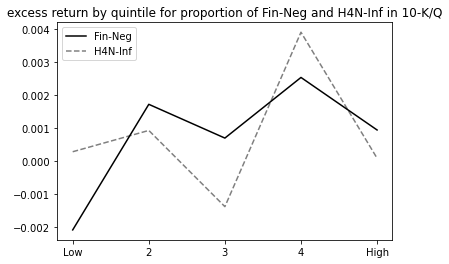

In [193]:
import matplotlib.pyplot as plt
plt.plot(fin_ret_mean, 'k', label='Fin-Neg')
plt.plot(h4n_ret_mean, '--k', alpha = 0.5, label = 'H4N-Inf')
plt.legend()
plt.xticks(np.arange(5), ['Low', '2', '3', '4', 'High'])
plt.title('excess return by quintile for proportion of Fin-Neg and H4N-Inf in 10-K/Q')
plt.savefig('1',dpi=200)
plt.show()

In [169]:
def get_tfidf_score(Dict):
    docs = list()
    for path in tqdm(data_file_list):
         text = Path(path).read_text(encoding="utf8").lower()
         docs.append(text)

    dict_df = pd.read_csv('dict.csv')

    dict_all = dict_df['Word'].to_numpy()

    for i in range(len(dict_all)):
        dict_all[i] = str(dict_all[i]).lower()

    tfidf = get_tfidf(dict_all, docs)

    mask_fin_neg = np.isin(dict_all,Dict)

    tf_sum = np.sum(tfidf,axis=1)
    tfidf_score = np.matmul(tfidf,mask_fin_neg)/tf_sum
    return tfidf_score

In [171]:
tfidf_score_fin_neg = get_tfidf_score(fin_neg)

100%|██████████| 10842/10842 [00:42<00:00, 254.75it/s]


.


In [174]:
tfidf_score_h4n_inf = get_tfidf_score(h4n_inf)

100%|██████████| 10842/10842 [00:54<00:00, 200.44it/s]


.


In [175]:
from tqdm import tqdm

df_tfidf = pd.DataFrame(data={'name':[], 'fin neg freq':[], 'h4n inf freq':[], 'return':[]})

i = 0
for path in tqdm(data_file_list):
    i += 1
    try:
        add = pd.DataFrame(data = {'name':[data_file_list[i]], 'fin neg freq':tfidf_score_fin_neg[i], 
                                   'h4n inf freq':tfidf_score_h4n_inf[i], 'return':[get_return(path)]})
        df_tfidf = pd.concat([df_tfidf,add], ignore_index=True)
    except:
        pass

  0%|          | 0/10842 [00:00<?, ?it/s]C:\Users\yiyan\AppData\Local\Temp\ipykernel_13216\1519286417.py:9: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ret = cik_ret.iloc[cik_ret.index.get_loc(datetime(yyyy,mm,dd), method='bfill')][3]
100%|██████████| 10842/10842 [07:56<00:00, 22.76it/s]


In [185]:
fin_neg_qt_tfidf = np.quantile(tfidf_score_fin_neg,[0,.2,.4,.6,.8,1])
h4n_inf_qt_tfidf = np.quantile(tfidf_score_h4n_inf,[0,.2,.4,.6,.8,1])

fin_ret_mean_tfidf = list()
h4n_ret_mean_tfidf = list()


for i in range(5):
    mean1 = np.mean(df_tfidf[(df_tfidf['fin neg freq']<fin_neg_qt_tfidf[i+1]) & (df_tfidf['fin neg freq']>=fin_neg_qt_tfidf[i])]['return'])
    mean2 = np.mean(df_tfidf[(df_tfidf['h4n inf freq']<h4n_inf_qt_tfidf[i+1]) & (df_tfidf['h4n inf freq']>=h4n_inf_qt_tfidf[i])]['return'])
    fin_ret_mean_tfidf.append(mean1)
    h4n_ret_mean_tfidf.append(mean2)

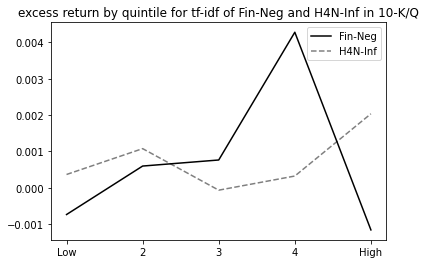

In [192]:
plt.plot(fin_ret_mean_tfidf, 'k', label='Fin-Neg')
plt.plot(h4n_ret_mean_tfidf, '--k', alpha = 0.5, label = 'H4N-Inf')
plt.legend()
plt.xticks(np.arange(5), ['Low', '2', '3', '4', 'High'])
plt.title('excess return by quintile for tf-idf of Fin-Neg and H4N-Inf in 10-K/Q')
plt.savefig('2',dpi=200)
plt.show()